In [2]:
import numpy as np
import pandas as pd
from Evaluator import ModelEvaluator
import torch
import random
from matplotlib import pylab as plt
from IPython.display import clear_output
import copy

In [4]:
data=pd.read_csv("./datasets/Colcom2018CleanedScaled.csv",header=0,sep=';')
data=golden_data[golden_data.type=='malicious']
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 11)


In [19]:
malData

array([[-31., -36., -86., ...,  35., -62.,  87.],
       [-31., -35., -84., ...,  36., -60.,  85.],
       [-33., -37., -85., ...,  37., -60.,  85.],
       ...,
       [-58., -58., -96., ..., -12.,  98.,  91.],
       [-58., -58., -97., ..., -11., 100.,  92.],
       [-55., -54., -99., ..., -11.,  99.,  92.]])

## control

In [20]:
totalEpochs=1000
totalNumAdversarialData=500
saveValue=totalEpochs-totalNumAdversarialData
if saveValue<=0:
    saveValue=0
totalItemsConv=0

In [21]:
features=['A','B','C','D','F','G','H','I','j','k']
df=pd.DataFrame(columns=features)

In [22]:
class MalwareEnv():
    def __init__(self,totalEpochs):
        # Actions we can take, decrease, increse
        self.action_space = 20  
        # Set start 
        self.state = np.asarray(malData[random.randint(0,498),:])
        #model to evaluate the reward
        self.evaluator=ModelEvaluator()
        #units to move
        self.block=10
        #number of items saved
        self.savedItems=0
        #pointcritic
        self.pointCritic=totalEpochs-totalNumAdversarialData
        #loss
        self.hit=0
        
    def reset(self):
        self.state = np.asarray(malData[random.randint(0,498),:])
        
        
    def step(self, action):
        
        if(action<9):
            self.state[action]+=self.block
        elif(action>=9 and action<19):
            self.state[action-9]-=self.block
            
        
    def reward(self):
        reward=-1
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
            self.hit+=1
            reward=+10
            self.saveItem()
                 
        return reward    
    
    def saveItem(self):
        
        
        if self.hit>self.pointCritic:
            
            print("saveddddddddddddddddddddddddddddddddddd")
            
            formatier=self.state.reshape(1,-1)[0]
            df.loc[self.savedItems]=formatier
            self.savedItems+=1
            

    def render_np(self):
        return self.state
    

In [23]:


l1 = 10
l2 = 24
l3 = 72
l4 = 20
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [24]:
epochs = copy.copy(totalEpochs)
losses = [] 
env = MalwareEnv(totalEpochs)


for i in range(epochs): 
    env.reset()
    state_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0 
    state1 = torch.from_numpy(state_).float() 
    status = 1 
    while(status == 1): 
        qval = model(state1.cuda()) 
        qval_ = qval.data.cpu().numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,20)
        else:
            action_ = np.argmax(qval_)
        
        env.step(action_) 
        state2_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0
        state2 = torch.from_numpy(state2_).float() 
        reward = env.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,10).cuda())
        maxQ = torch.max(newQ) 
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        loss = loss_fn(X.cuda(), Y.cuda()) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: 
            status = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

saveddddddddddddddddddddddddddddddddddd
999 2.180121421813965


D:\programas\anaco\envs\latest tf 101021\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [25]:
losses
#clear_output(wait=True)

[409.9664001464844,
 172.87860107421875,
 557.149658203125,
 118.41144561767578,
 13.098675727844238,
 401.9653625488281,
 726.1512451171875,
 222.7562255859375,
 20.617813110351562,
 98.37713623046875,
 84.92450714111328,
 682.3787231445312,
 207.3854217529297,
 497.21807861328125,
 414.1816711425781,
 633.6137084960938,
 311.4285583496094,
 426.9026794433594,
 546.2273559570312,
 101.60843658447266,
 14.855911254882812,
 270.5572814941406,
 197.26695251464844,
 148.57839965820312,
 388.1447448730469,
 423.94903564453125,
 372.37896728515625,
 365.38446044921875,
 349.7406005859375,
 625.8788452148438,
 150.6671142578125,
 409.1578063964844,
 597.8470458984375,
 432.3473815917969,
 437.56451416015625,
 86.24993896484375,
 4.664058685302734,
 954.968505859375,
 283.599365234375,
 18.796550750732422,
 740.0933227539062,
 631.8079223632812,
 76.87802124023438,
 134.295166015625,
 358.5669860839844,
 226.71609497070312,
 128.08790588378906,
 124.53610229492188,
 387.63311767578125,
 0.246

Text(0, 0.5, 'Loss')

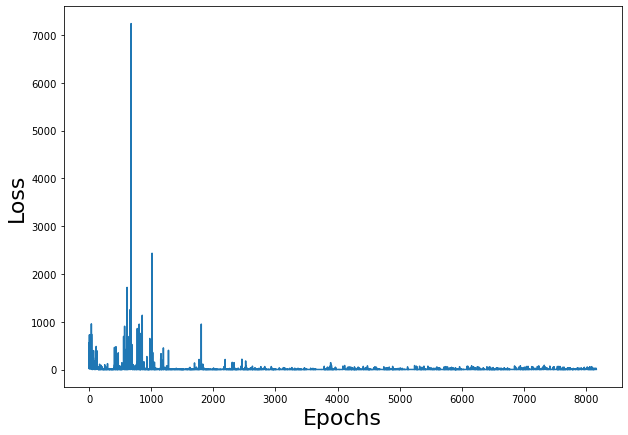

In [26]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [27]:
df

,A,B,C,D,F,G,H,I,j,k
0,-8.0,-23.0,-14.0,95.0,-24.0,15.0,-81.0,23.0,-37.0,23.0
1,-62.0,-52.0,-66.0,-61.0,-153.0,-17.0,-28.0,75.0,-46.0,-19.0
2,-2.0,-67.0,-81.0,-24.0,15.0,-62.0,-72.0,77.0,-35.0,30.0
3,-72.0,-80.0,-45.0,-80.0,-54.0,-15.0,7.0,43.0,-96.0,62.0
4,0.0,-32.0,75.0,121.0,63.0,39.0,25.0,-62.0,28.0,35.0
...,...,...,...,...,...,...,...,...,...,...
495,-62.0,-47.0,-83.0,35.0,-40.0,-37.0,-105.0,71.0,-23.0,-20.0
496,-44.0,-54.0,-40.0,-69.0,-51.0,34.0,-7.0,62.0,7.0,16.0
497,8.0,-65.0,90.0,-22.0,-62.0,-62.0,6.0,9.0,-97.0,59.0
498,59.0,-61.0,29.0,-89.0,-35.0,-52.0,-33.0,74.0,-43.0,39.0


In [28]:
df.to_csv('datasets/Adversarial_data.csv' ,header=False,index=False)

In [29]:
torch.save(model.state_dict(), 'DRLMalwareModificator.sav')